# Prédiction de la performance du SP500 à partir d'indices de "sentiment du marché"

**Projet Python - 2A ENSAE** . 

Elena Loumagne / Jérémie Darracq 

## Introduction 

**Objectifs :** Il s'agit de prédire les performances du SP500 à partir d'indices de "sentiment du marché". Il existe de nombreux indicateurs de "sentiment du marché" mais dans ce projet nous choisirons un indicateur direct à savoir l'indice de volatilité du SP500, ou plutôt indice VIX, et un indicateur indirect que nous allons construire à partir d'une base de donnée d'articles traitant du SP500. 

**Projet :** il se découpe en trois parties 

- 1ère partie (voir notebook_récup_data_webscrapping /notebook_récup_data_API) : l'extraction des données sur la performance du SP500 (indice de performance SP500) et sa volatilité (indice VIX)/ la récupération des articles traitant des companies du SP500 et des tweets financiers via des API.   

- 2ème partie (notebook_récup_data_API) : Le traitement des données incluant le nettoyage du résumé des articles. 

- 3ème partie (notebook_analyse_data) : L'analyse des données par des statistiques descriptives /l'analyse de sentiment puis une construction de notre indice indirecte pour la réalisation d'un modèle de prédiction. 




## Sources

- Pour l'API finhub : https://python.plainenglish.io/access-historical-financial-news-headlines-with-python-be1b8faaea9f      
- Pour l'API twitter : https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178    
- Pour la prédiction : https://sentometrics-research.com/sentometrics/articles/applications/vix.html​




## Definitions 
- *"sentiment du marché" :* renvoie à l’humeur générale des investisseurs sur un marché particulier. Le sentiment du marché a bien sûr un impact sur le cours du marché concerné. Lorsque le cours est en hausse, on dit souvent du sentiment du marché qu’il est haussier. Mais, lorsque le cours du marché est en baisse, on dit que le sentiment du marché est baissier. L’expression « sentiment du marché » renvoie à l’émotion qui domine parmi les investisseurs d’un marché donné : par exemple, la peur ou l’optimisme. 


- *SP500 :* indice boursier basé sur 500 grandes sociétés cotées sur les bourses aux États-Unis (NYSE ou NASDAQ). Il couvre environ 80 % du marché boursier américain par sa capitalisation.  



-  *indice VIX :* indicateur de volatilité du marché financier établit par le Chicago Board option Exchange.Le cours des options est considéré comme une bonne mesure de la volatilité car si quelque chose suscite de l’inquiétude sur le marché, les traders et les investisseurs ont tendance à se positionner à l’achat sur les options, ce qui entraîne une hausse des cours. C’est la raison pour laquelle le VIX est également appelé « indice de la peur », puisqu’il mesure le niveau de peur et de stress sur le marché.


- *FINHUB :* API fournissant des articles financiers concernant les plus grandes entreprises mondiales. 

## Import des packages 

In [168]:
## Package pour la statistique descriptive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import imshow
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
import datetime

## Packages pour l'analyse de sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS


## Package pour le modèle de prédiction
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf


## I - Exploration des données et statistiques descriptives

Dans cette partie, nous allons étudier la base de donnée d'articles que nous avons récupéré.

In [169]:
## On importe les articles propres 
article_data = pd.read_csv("Data/data_finhub.csv")

### Statistiques descriptives

In [170]:
article_data.groupby("source")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,26,18,13,3,17,10,23,0,24,11,...,15,14,16,4,12,9,25,22,7,8
source,Yahoo,SeekingAlpha,MarketWatch,CNBC,Reuters,GuruFocus,Thefly.com,Alliance News,TipRanks,InvestorPlace,...,PennyStocks,PR Newswire,Preferred Stock Channel,Dividend Channel,Market News Video,GlobeNewswire,United Press International,The Online Investor,Finnhub,Fintel
abstract,5996,1802,1251,567,387,260,188,70,58,48,...,9,6,5,5,5,2,2,1,1,0


In [171]:
article_data.groupby("company")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,15,24,37,1,4,44,31,17,48,11,...,0,19,43,40,41,18,34,14,13,3
company,COST,INTC,NVDA,AAPL,AMZN,TSLA,MRK,DIS,WMT,BRK.B,...,AAL,FDX,TMUS,PM,SLB,EA,NDAQ,COF,CBOE,AIG
abstract,243,240,240,240,239,238,238,237,237,236,...,216,213,211,209,204,133,127,119,106,97


Des tableaux ci-dessus on constate que : 
- Nos articles proviennent majoritairement des site Yahoo, SeekingAlpha et MarketWatch
- Les entreprises les plus citées sont Google et Méta mais les nombres de citations pour chaque entreprise est assez similaire

Notre base de donnée présente donc des sources diverses et traite de manière homogène chaque entreprise du SP500

In [172]:
article_data_2=article_data.sort_values("date",ascending=True)

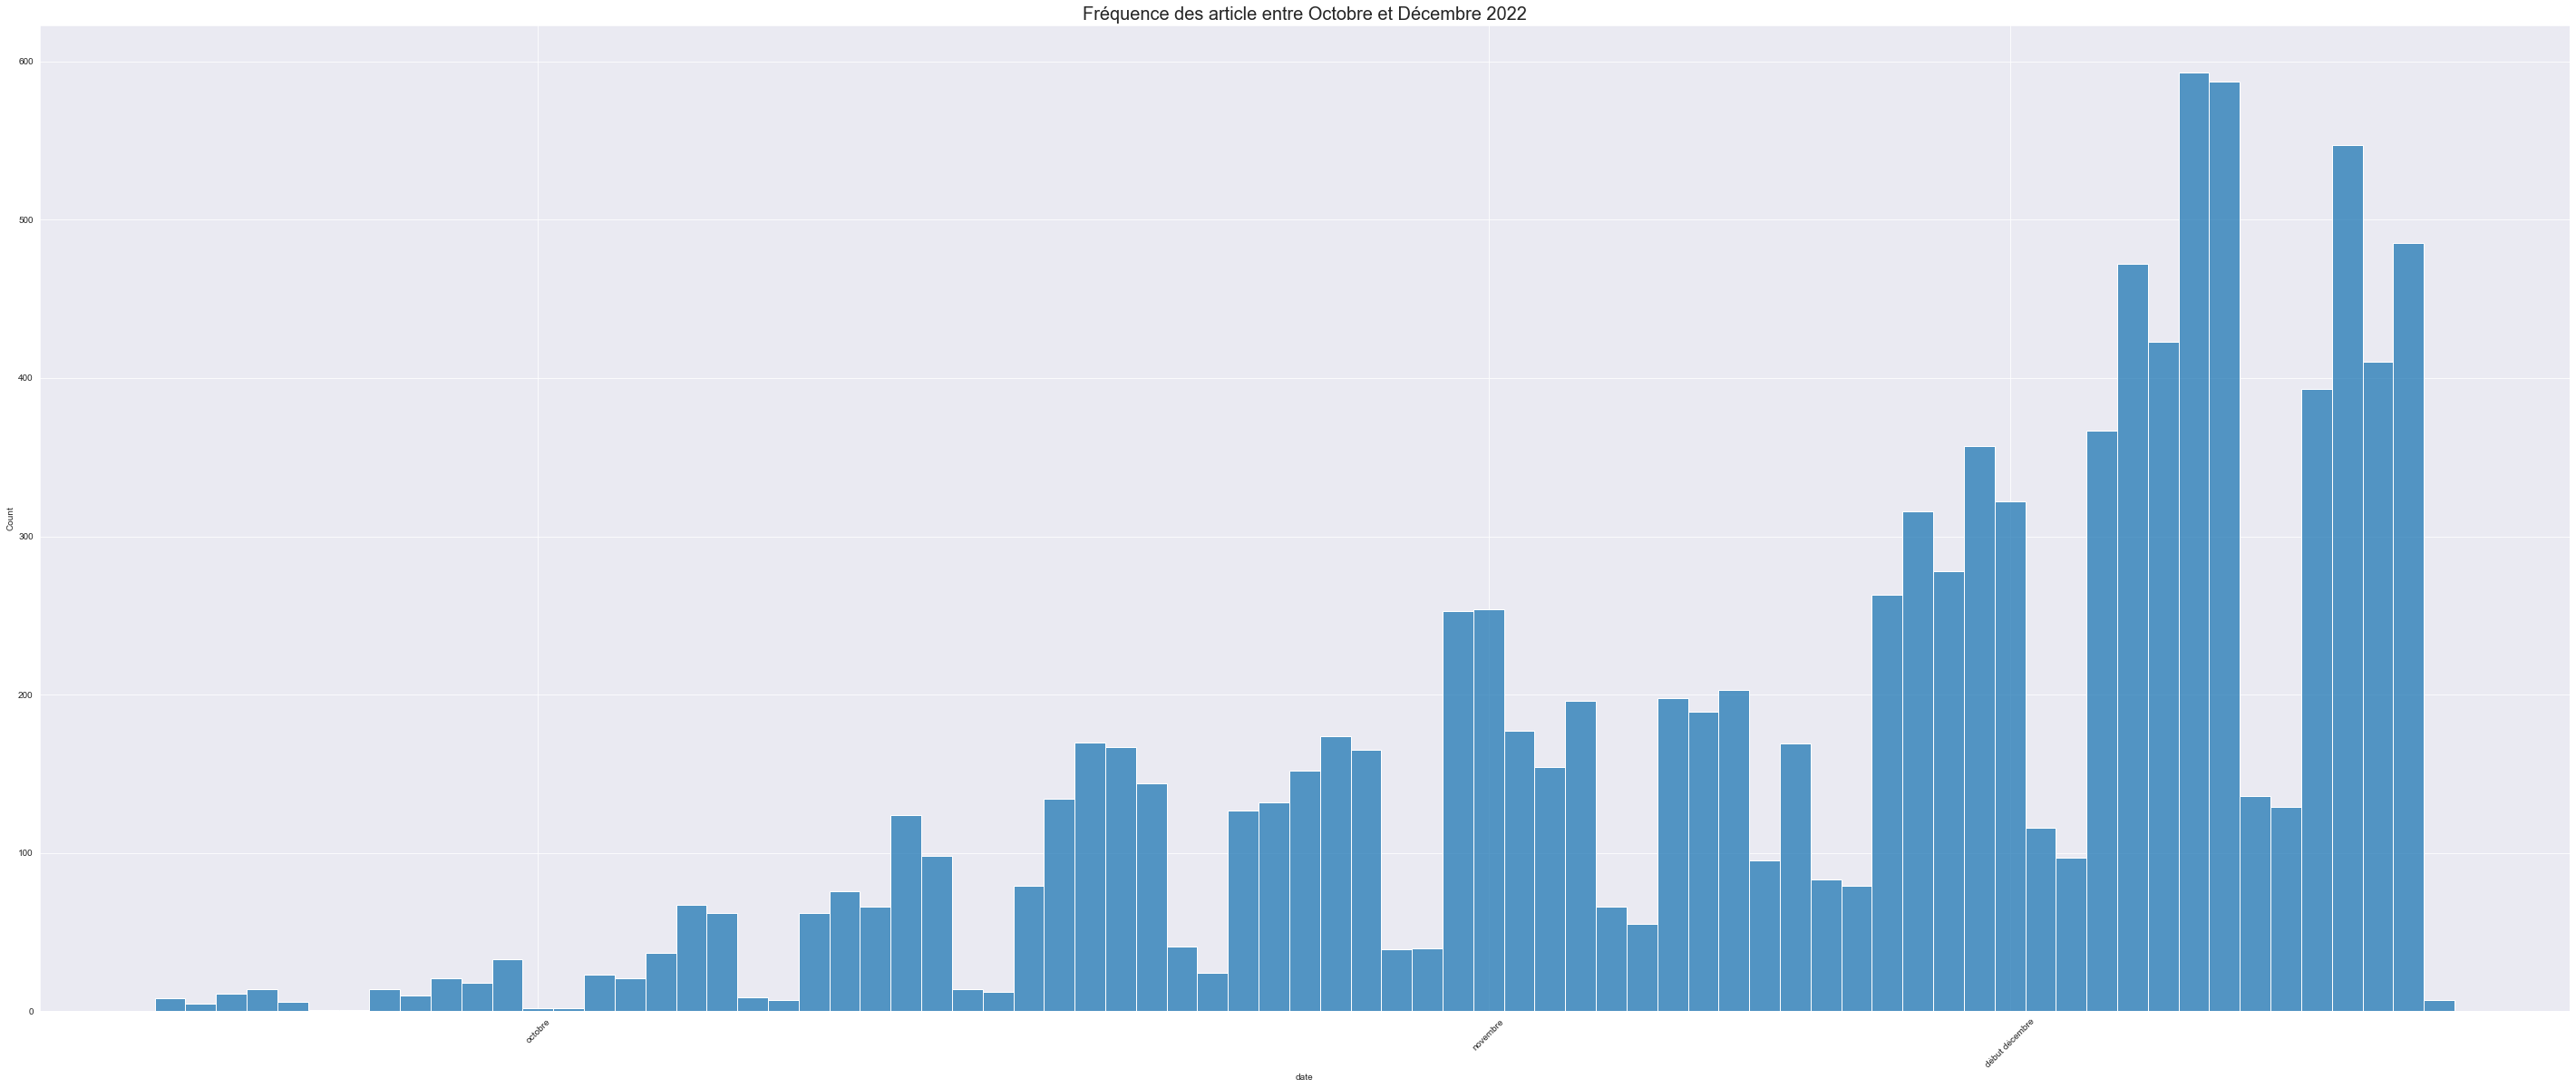

In [173]:
# Evolution de la fréquence des articles entre mars et Décembre 2022
cpalette = sns.diverging_palette(150, 30, n=3)
plt.figure(figsize=(50, 20))
sns.set_style('darkgrid')
sns.histplot(article_data_2, x="date")
plt.title("Fréquence des article entre Octobre et Décembre 2022", size=20)
t2=["10/15/22","11/15/22","12/02/22"]
plt.xticks(t2,["octobre","novembre","début décembre"],rotation = '45')
plt.show()


Du graphique ci-dessous on constate que : 
- Il y a peu de production d'article en début de période (de début à fin octobre) mais cela augmente au fur et à mesure jusqu'à atteindre un pic début décembre. Le nombre d'article s'établit entre 200 et 400 articles par jour. 

## II- Analyse de sentiment 

L'analyse de sentiment va nous permettre de faire ressortir un "sentiment du marché" au sein de notre base d'articles. 


### Calcul du sentiment des articles à partir de la polarité
Ceci est fait grâce au package **SentimentIntensityAnalyzer** qui renvoie la polarité positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif.

In [174]:
sia = SentimentIntensityAnalyzer() # analiseur des sentiments

# ajout de mots spécifiques à la finance au lexique : moyenne du score de sentiment entre -4 (très négatif) et 4 (très positif)

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_words = {**dictOfpos, **dictOfneg} # déballage du dictionnaire

sia.lexicon.update(Financial_words)

In [175]:
## On calcul le sentiment des résumés de chaque article
article_data["sentiment_score_abstract"]=article_data["abstract_stemmed"].apply(lambda x: sia.polarity_scores(str(x))['compound'])

Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet :

In [176]:
def article_label(score):
    if score > 0.00 :
        return "positif"
    if score < 0.00 :
        return "negatif"
    else :
        return "neutre"

def article_label_score(score):
    if score > 0.00 :
        return 1
    if score < 0.00 :
        return -1
    else :
        return 0

article_data["label_abstract"]=article_data["sentiment_score_abstract"].apply(article_label)
article_data["label_score_abstract"]=article_data["sentiment_score_abstract"].apply(article_label_score)
article_data


,index,date,headline,company,abstract,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,0,12/15/22,Amazon goes TikTok. Here's how it will work.,AMZN,Amazon has begun rolling out a short-form vide...,Yahoo,amazon begun rolling short-form video photo fe...,amazon begun roll short-form video photo feed app,0.1779,positif,1
1,1,12/15/22,Amazon reportedly reaches agreement with the E...,AMZN,Yahoo Finance Live examines the latest develop...,Yahoo,yahoo finance live examines latest development...,yahoo financ live examin latest develop amazon...,0.5994,positif,1
2,2,12/15/22,Why More Shoppers Are Turning to Reddit for Ho...,AMZN,"This holiday season, as gift-buyers try to avo...",Yahoo,"holiday season, gift-buyers try avoid fake rev...","holiday season, gift-buy tri avoid fake review...",0.2732,positif,1
3,3,12/15/22,Here's Why I End Up Overspending at Target -- ...,AMZN,There's a joke that it's impossible to make a ...,Yahoo,joke impossible make shopping trip target with...,joke imposs make shop trip target without spen...,0.8750,positif,1
4,4,12/15/22,"Retail stocks including Macy's, Target get smo...",AMZN,An ugly day for retail stocks followed an ugly...,Yahoo,ugly day retail stocks followed ugly retail sa...,ugli day retail stock follow ugli retail sale ...,0.0000,neutre,0
...,...,...,...,...,...,...,...,...,...,...,...
10876,10881,10/06/22,Former Amazon cloud engineer gets probation fo...,COF,"The hack compromised about 140,000 Social Secu...",Yahoo,"hack compromised , social security numbers , b...","hack compromis , social secur number , bank ac...",0.0516,positif,1
10877,10882,10/05/22,Capital One Financial Corporation to Webcast C...,COF,"On Thursday, October 27, 2022, at approximatel...",Yahoo,"thursday, october , , approximately : pm easte...","thursday, octob , , approxim : pm eastern time...",0.7184,positif,1
10878,10883,10/04/22,Why Is RIVN Stock Up Today? Rivian Confirmed 2...,COF,RIVN stock is up after Rivian announced it pro...,InvestorPlace,"rivn stock rivian announced produced , vehicle...","rivn stock rivian announc produc , vehicl trac...",0.0000,neutre,0
10879,10884,10/03/22,"Q3 2022 Bank Analysts' Top 3 Picks, Earnings E...",COF,"Big bank stocks are down 27% on average, but a...",SeekingAlpha,"big bank stocks average, analysts see sunny da...","big bank stock average, analyst see sunni day ...",0.0000,neutre,0


#### Statistiques descriptives du sentiment des articles 

Text(0.5, 1.0, 'Répartition des articles selon leur sentiment')

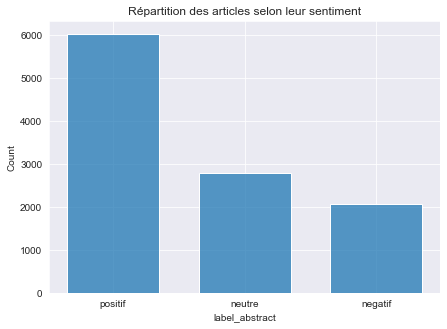

In [177]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(article_data.sort_values("label_abstract", ascending=False), x="label_abstract",  shrink=0.7)
plt.title("Répartition des articles selon leur sentiment")

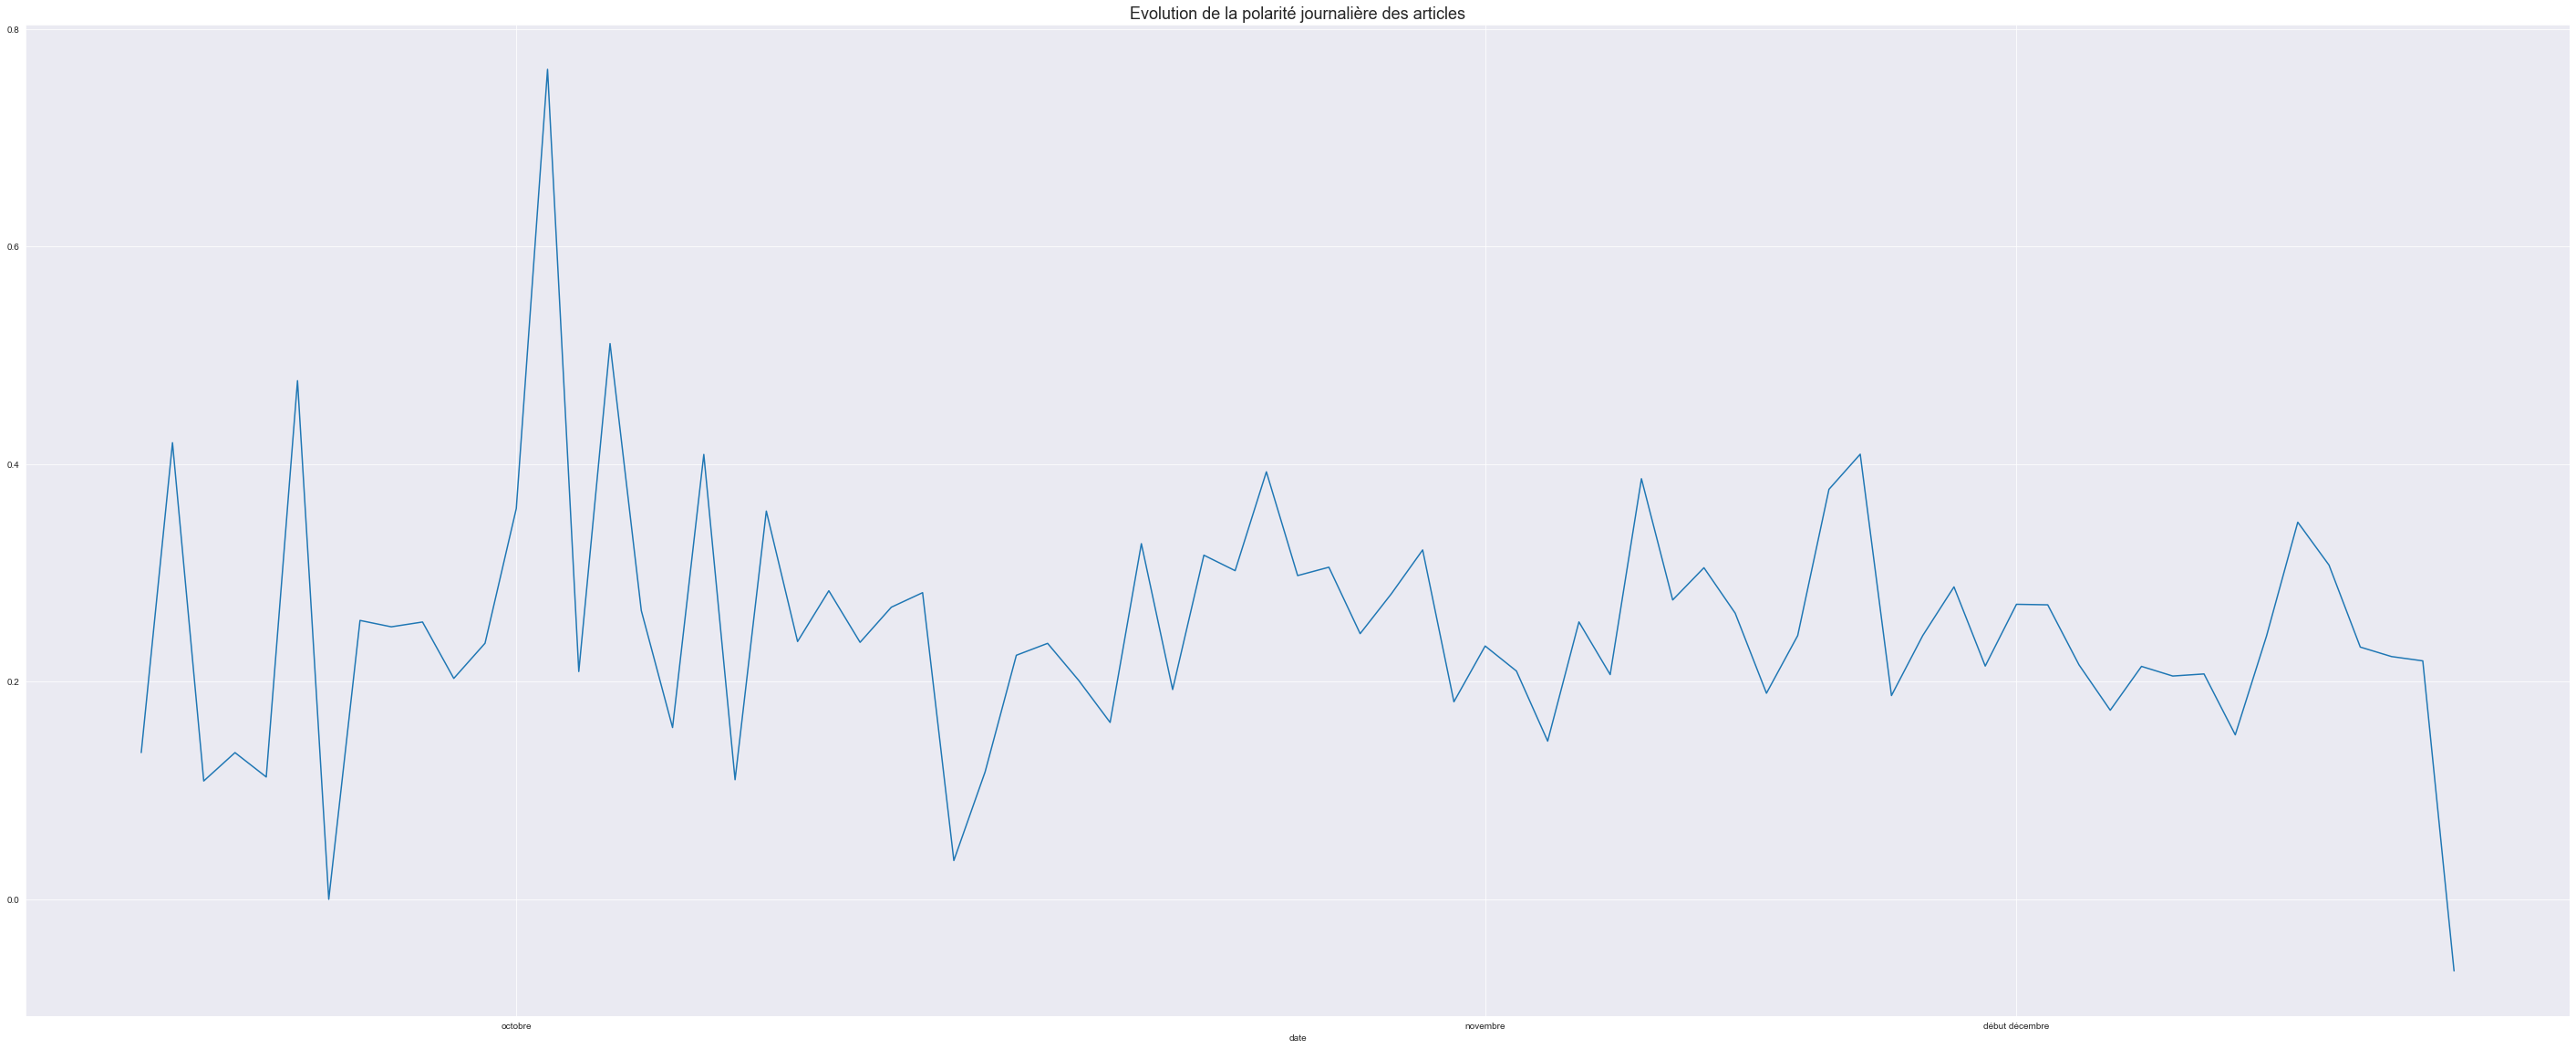

In [178]:
# Evolution de la polarité journalière des articles entre du 01 octobre 2022 au 15 décembre 2022
plt.figure(figsize=(50, 20))
plt.xlabel('date')
df2 = article_data[['date','sentiment_score_abstract']].groupby('date').mean()
plt.plot(df2)
plt.title("Evolution de la polarité journalière des articles", size=18)
#plt.xticks(rotation='45')
t2=["10/15/22","11/15/22","12/02/22"]
plt.xticks(t2,["octobre","novembre","début décembre"])
plt.show()

Des graphiques ci-dessus on constate que : 
- Il y a environ 3 fois plus d'articles positifs que négatifs et 2 fois plus d'articles positifs que neutres. 
- En moyenne, la polarité des articles est au dessus de 0 sur la période. Celle-ci reste globalement entre 0.1 et 0.4 sur la période. 

### Relation entre le type de sentiment et les entreprises

<Figure size 7200x7200 with 0 Axes>

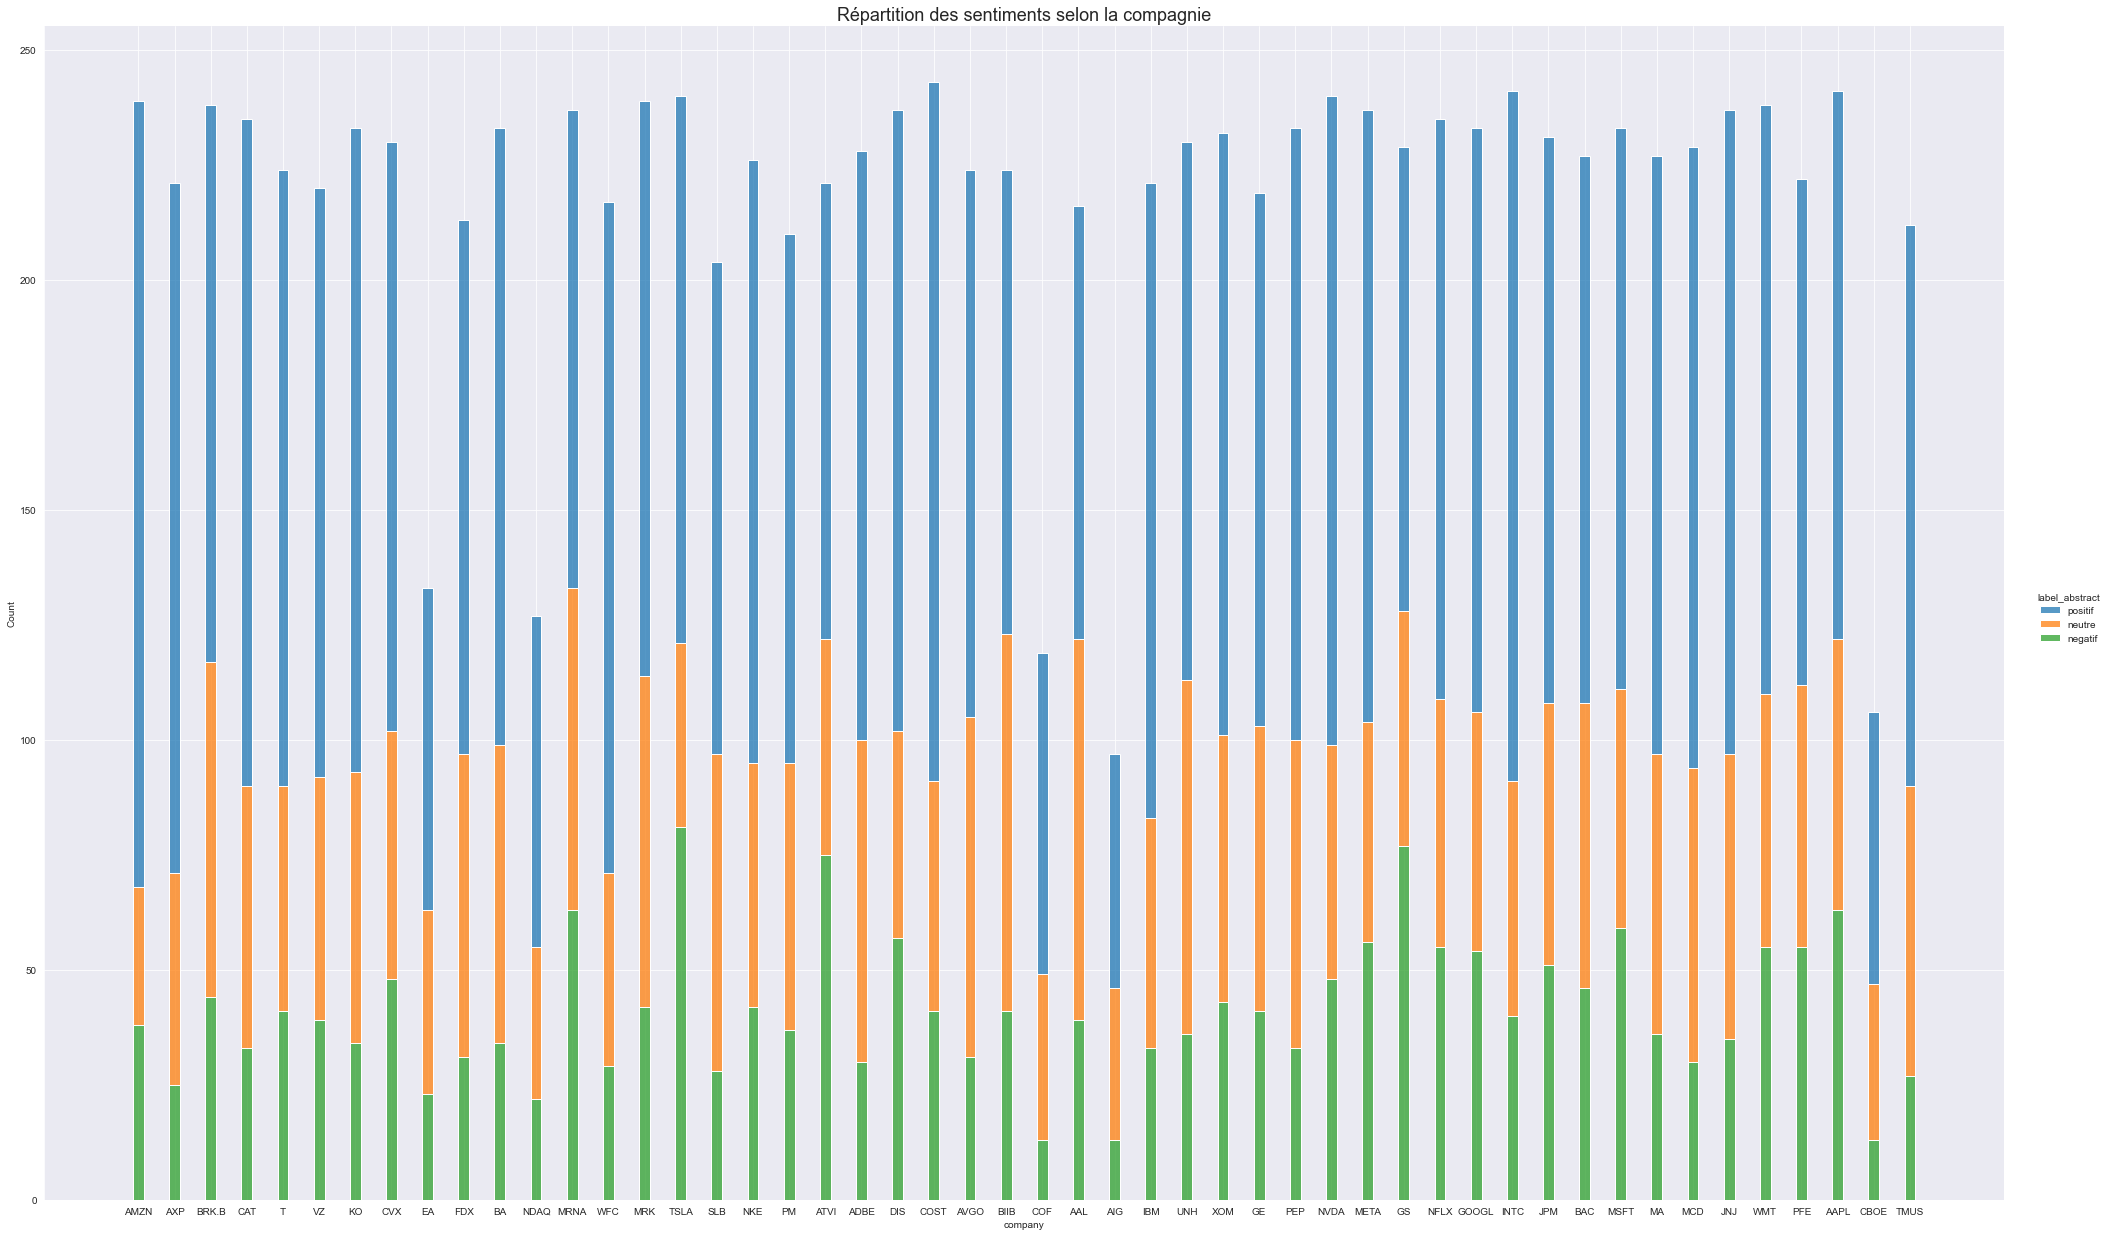

In [179]:
plt.figure(figsize=(100, 100))
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(article_data.sort_values("label_abstract", ascending=False), x="company", hue="label_abstract", multiple="stack", shrink=0.3,height=17, aspect=20/12)

plt.title("Répartition des sentiments selon la compagnie",size=18)
plt.show()

Du graphique ci-dessus on constate que : 
- les articles positifs représentent la plus grande part des articles citant les companies du SP500 suivis des articles neutres puis négatifs illustrant un possible "sentiment du marché" haussier sur la période choisie.
- la répartition des articles positifs, neutres et négatifs semblent relativement similaire ce qui suggère une indépendance entre le type de sentiment et la companie choisie. Cela illustrerait donc une sorte de tendance de marché / sentiment global du marché. 

Nous allons donc étudier la relation entre la variable "label_abstract" qui nous renseigne sur le type de sentiment et la variable "company" qui nous renseigne sur le type de company du SP500 à l'aide d'un test d'indépendance du Khi-deux et d'un test de Cramer.

### Test du Chi-deux et Test de Cramer 

- Test du Chi-deux : Il s'agit d'un test qui compare la distribution des modalités de deux variables qualitatives. L'hypothèse du test est l'indépendance entre les deux variables. L'hypothèse est rejetée si la statistique calculée est supérieure à la valeur critique correspondante. On peut également utiliser la p-valeur qui est comparée à un seuil de significativité. Dans ce cas, l'hypothèse nulle est rejetée si cette p-valeur est inférieure au seuil. il permet donc de savoir si les variables entretiennent une relation, avec un degré de certitude plus ou moins grand. Par contre, il ne renseigne pas sur l’intensité de cette relation et la p-valeur est très sensible à la taille de l'échantillon.

- Test de Cramer : Plus le V de Cramer s’approche de 1, plus l’intensité de la relation est forte.


In [180]:
## Réalisation du test du Chi-deux 
cont=pd.crosstab(article_data["label_abstract"],article_data["company"])
khi2, pval , ddl , contingent_theorique = chi2_contingency(cont)
print('statistic: ',khi2, '\nP-value: ',pval ,'\nddl: ', ddl)

statistic:  359.7451203159351 
P-value:  1.4467188654191377e-31 
ddl:  98


In [181]:
## Fonction qui calcul le V de cramer 
def cramers(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = sum(crosstab.sum())
    return np.sqrt(chi2/(n*(min(crosstab.shape)-1)))

cramers(cont)

0.12857248945037694

Des résultats ci-dessus nous constatons que : 
- Au seuil de 5%, on rejette l'hypothèse nulle d'indépendance entre le type de sentiment et le type de companie du SP500 donc il existe toutefois une relation significative entre nos 2 variables quantitatives (test du Chi-deux )
- L'intensité de la relation reste cependant très faible voir nulle, le V de cramer étant relativement proche de 0. 

Donc il semble possible que le type de sentiment des articles ne soit pas totalement liée à l'entreprise du SP500 qu'il considère mais possiblement à une tendance générale qu'on peut identifier comme le "sentiment du marché".

### Étude approfondies des sentiments des articles sur le SP500
On veut ici visualiser les wordclouds selon le sentiment.

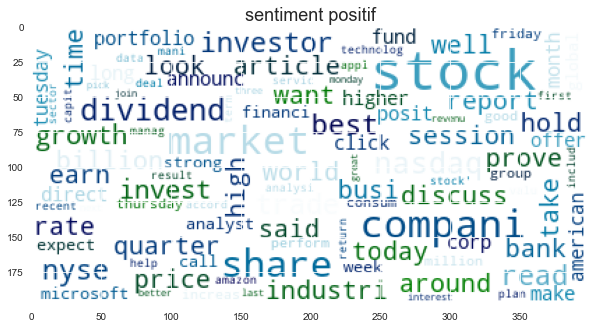

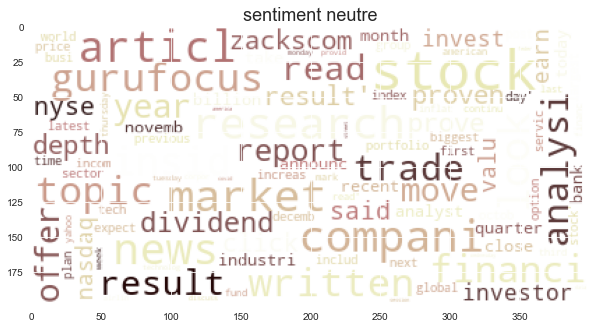

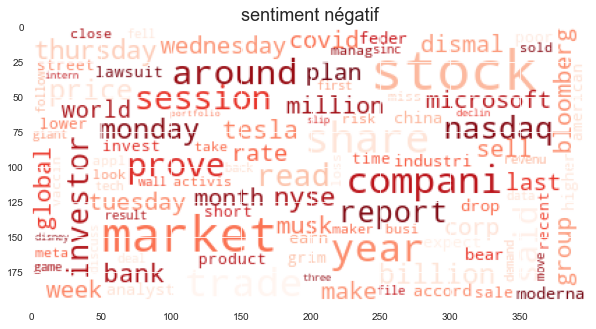

In [182]:
positive_article = []
negative_article = []
neutral_article = []

for i in range(0, article_data.shape[0]):
    if article_data['label_score_abstract'][i] == 0:
        neutral_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == 1:
        positive_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == -1:
        negative_article.append(article_data['abstract_stemmed'][i])

stopwords = set(STOPWORDS)

def show_wordcloud(data, sentiment,color):
    wordcloud = WordCloud(
        background_color='white',
        colormap=color,
        stopwords=stopwords,
        collocations=False, 
        collocation_threshold=100,
        max_words=100,
        max_font_size=40, 
        min_word_length=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    figure(1, figsize=(10, 10))
    imshow(wordcloud)
    plt.title("sentiment " + sentiment,size=18)
    plt.show()

show_wordcloud(positive_article,"positif","ocean_r")
show_wordcloud(neutral_article,"neutre",'pink_r')
show_wordcloud(negative_article,"négatif","Reds")

Des nuages de mots ci-dessus on remarque que les articles évoquant le covid ou des baisse du marché sont affiliés à un sentiment négatif alors que les articles parlant de croissance sont davantage associés à un sentiment positif.

En supposant, possible cette "tendance générale" / "sentiment de marché" nous allons voir si celle-ci peut nous permettre de prédire les performances du SP500 à partir de la construction d'un indice indirect de "sentiment du marché"

## III - Construction de l'indice indirect de "sentiment du marché"

Après l'identification du "sentiment du marché", nous allons maintenant construire un indice représentant le "sentiment" journalier du marché en utilisant le fait qu'un groupe d'entreprises a plus d'impact sur le marché boursier. En effet, si une grande partie des articles mentionnant une des entrerpises de ce groupe sont positifs, le sentiment du marché sera davantage positif que si cela avait été des articles mentionnant des entreprises moins influentes.  
Nous proposons donc dans la suite une méthode spécifique de calcul de cette indice. Pour cela, nous nous sommes inspirés de méthodes statistiques de construction d'indice.

D'abord, nous découpons nos compagnies selon 2 groupes d'appartenance : 
- 1er groupe : les 14 compagnies ayant la plus grosse valorisation boursière du SP500 
- 2ème groupe : le reste des companies 

In [183]:
## Création d'une variable catégorielle pour classifier nos compagnies en 2 groupes 
List_tiers1 = ["AMZN","AAPL","META","GOOGL","BRK.B","TSLA","NVDA","JPM","JNJ","XOM","BAC","MSFT","WFC","T"]
List_tiers2 = ["PFE","NFLX","MA","MCD","GS",'INTC','TMUS',"WMT",'CBOE',"MRK","BA","MRNA","NDAQ","NKE","SLB","VZ","AXP","KAT","CVX","KO","EA","FDX","GE","IBM","UNH","PEP","COST","DIS","PM","ATVI","ADBE","AAL","AIG","BIIB","AVGO","COF"]

def categ(company):
    if company in List_tiers1:
        return "1"
    else:
        return "2"

article_data["categorie"]=article_data["company"].apply(categ)


Nous calculons maintenant un indicateur qui représente le nombre d'articles positifs nets moyen ($\frac{articles\_positifs - articles\_négatifs}{nombre\_total\_d'articles}$) pour chaque groupe d'entreprises et cela sur chaque jour.  
Ensuite, on multiplie cet indicateur par un poids dépendant du groupe d'appartenance de l'entreprise au SP500 (ici nous avons choisi 0.9 pour le groupe 1 car ce sont les entreprises qui influent le plus sur le SP500 et 0.1 pour le groupe 2).

In [184]:
df_indice= (article_data.groupby(["date","categorie"])["label_score_abstract"].sum()/article_data.groupby(["date","categorie"])["label_score_abstract"].count()).reset_index()

def formula_indice(categorie,label_score):
    if categorie=="1":
        return(label_score*0.9)
    else:
        return(label_score*0.1)
    

df_indice["label_score_abstract_pondere"]=df_indice.apply(lambda x: formula_indice(x.categorie,x.label_score_abstract),axis=1)
df_indice
   

,date,categorie,label_score_abstract,label_score_abstract_pondere
0,10/03/22,2,0.375000,0.037500
1,10/04/22,2,0.800000,0.080000
2,10/05/22,2,0.181818,0.018182
3,10/06/22,2,0.357143,0.035714
4,10/07/22,2,0.333333,0.033333
...,...,...,...,...
125,12/14/22,2,0.397129,0.039713
126,12/15/22,1,0.353175,0.317857
127,12/15/22,2,0.407725,0.040773
128,12/16/22,1,-0.666667,-0.600000


On somme finalement l'indicateur de chaque groupe d'entreprises pour chaque jour.

In [185]:
df_indice = df_indice.groupby("date")["label_score_abstract_pondere"].sum().reset_index()
df_indice

,date,label_score_abstract_pondere
0,10/03/22,0.037500
1,10/04/22,0.080000
2,10/05/22,0.018182
3,10/06/22,0.035714
4,10/07/22,0.033333
...,...,...
70,12/12/22,0.447250
71,12/13/22,0.389432
72,12/14/22,0.290459
73,12/15/22,0.358630


Enfin après standardisation, on crée notre indice en sommant le score de polarité sentimentale moyen sur la journée des articles et les indicateurs des 2 groupes. 

In [186]:
score_polarite_sentiment_moyen = article_data.groupby('date')["sentiment_score_abstract"].mean().reset_index()
score_polarite_sentiment_moyen
df_indice=df_indice.merge(score_polarite_sentiment_moyen,how="left")
df_indice

,date,label_score_abstract_pondere,sentiment_score_abstract
0,10/03/22,0.037500,0.134837
1,10/04/22,0.080000,0.419720
2,10/05/22,0.018182,0.108764
3,10/06/22,0.035714,0.134821
4,10/07/22,0.033333,0.112400
...,...,...,...
70,12/12/22,0.447250,0.307180
71,12/13/22,0.389432,0.231847
72,12/14/22,0.290459,0.223127
73,12/15/22,0.358630,0.219160


In [187]:
df_indice['label_score_abstract_pondere'] = preprocessing.scale(df_indice['label_score_abstract_pondere'])
df_indice['sentiment_score_abstract'] = preprocessing.scale(df_indice['sentiment_score_abstract'])

df_indice["indice"] = df_indice['label_score_abstract_pondere'] + df_indice['sentiment_score_abstract']
df_indice

,date,label_score_abstract_pondere,sentiment_score_abstract,indice
0,10/03/22,-1.081963,-1.016693,-2.098656
1,10/04/22,-0.924033,1.479833,0.555800
2,10/05/22,-1.153750,-1.245187,-2.398937
3,10/06/22,-1.088599,-1.016833,-2.105433
4,10/07/22,-1.097447,-1.213320,-2.310767
...,...,...,...,...
70,12/12/22,0.440670,0.493607,0.934277
71,12/13/22,0.225821,-0.166566,0.059255
72,12/14/22,-0.141965,-0.242978,-0.384942
73,12/15/22,0.111358,-0.277741,-0.166384


## IV - Modèle de prédiction

Dans cette partie, nous allons d'abord étudier l'utilité de notre indice de "sentiment de marché" dans la prédiction des performances du SP500 puis proposer avec l'indice VIX du SP500 un modèle de prédiction augmenté.

In [188]:
## On importe les indices de volatilité et de performance du SP500 webscrappés 
df_sp500 = pd.read_csv('Data/data_sp500.csv')
df_vix = pd.read_csv('Data/data_vix.csv')

### Régression linéaire I : l'utilité de notre indice "sentiment de marché"

Nous allons régresser l'indice de performance du SP500 ( variable "dernier_SP500") sur la variable "sentiment score abstract" (variable simple résultat de notre analyse de sentiment) puis regresser l'indice de performance du SP500 sur notre indice de "sentiment du marché" (variable composite) pour comparer l'efficacité des deux régressions. 

In [189]:
## On modifie les dates de façon à pouvoir fusionner nos dataframes
def modif_date(liste):
    liste_modif = liste[0:6]+'20'+liste[6:len(liste)]
    return liste_modif

df_indice["date"]=df_indice["date"].apply(lambda x : modif_date(x))

def convert(date_time):
    format = '%m/%d/%Y' 
    datetime_str = datetime.datetime.strptime(date_time, format)
 
    return datetime_str

df_indice["date"]= df_indice['date'].apply(lambda x : convert(x))

df_vix["date"]= df_vix["date"].astype('datetime64[ns]')
df_sp500["date"]= df_sp500["date"].astype('datetime64[ns]')
df_indice["date"]= df_indice["date"].astype('datetime64[ns]')

In [190]:
df_reg = df_indice.merge(df_vix,how="left",on="date")
df_reg_globale = df_reg.merge(df_sp500,how="left",on="date")
df_reg_globale.drop(["ouverture_x","higher_x","lower_x","variation_x","ouverture_y","higher_y","lower_y","variation_y"],axis=1,inplace=True)
df_reg_globale

,date,label_score_abstract_pondere,sentiment_score_abstract,indice,dernier_VIX,dernier_SP500
0,2022-10-03,-1.081963,-1.016693,-2.098656,30.10,3678.43
1,2022-10-04,-0.924033,1.479833,0.555800,29.07,3790.93
2,2022-10-05,-1.153750,-1.245187,-2.398937,28.55,3783.28
3,2022-10-06,-1.088599,-1.016833,-2.105433,30.52,3744.52
4,2022-10-07,-1.097447,-1.213320,-2.310767,31.36,3639.66
...,...,...,...,...,...,...
71,2022-12-12,0.440670,0.493607,0.934277,25.00,3990.56
72,2022-12-13,0.225821,-0.166566,0.059255,22.55,4019.65
73,2022-12-14,-0.141965,-0.242978,-0.384942,21.14,3995.32
74,2022-12-15,0.111358,-0.277741,-0.166384,22.83,3895.75


In [191]:
## Régression linéaire de "dernier_SP500" sur la variable "sentiment_score_abstract"
X = df_reg_globale[["sentiment_score_abstract"]]
Y = df_reg_globale[["dernier_SP500"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

## Évaluation du modèle sur base d'apprentissage 
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 144.4975029451213
le score R2 est 0.0013146879892181884




In [192]:
## Régression linéaire de "dernier_SP500" sur la variable "indice"
X = df_reg_globale[["indice"]]
Y = df_reg_globale[["dernier_SP500"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

## Évaluation de notre modèle sur base d'apprentissage 
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 140.87281307513248
le score R2 est 0.050789895976922295




Des résultats ci-dessus on constate que : 
- la variable "sentiment_score_abstract" explique 0.13% des variations du SP500 sur la période, ce qui reste faible    
- la variable "indice" explique 5% des variations du SP500 sur la période          


On en déduit que la construction de notre indice s'avère plus pertinente pour expliquer les variations du SP500 que la variable originale du score de sentiment. Même si le R2 reste relativement faible, notre indice explique une part non-négligeable de la variance du SP500. 


Text(0.5, 1.0, 'Régression du SP500 sur le sentiment du marché')

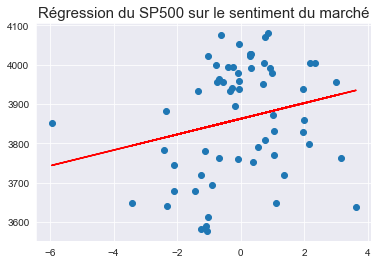

In [193]:

plt.plot(X_train,y_train_predict,"r")

plt.scatter(X_train,Y_train)
plt.title("Régression du SP500 sur le sentiment du marché",size=15)


### Régression linéaire II : Modèle de prédiction augmenté 


In [194]:
## Régression linéaire de "dernier_SP500" sur "indice" et "dernier_VIX"
xvars = ['dernier_VIX', 'indice']

df2 = df_reg_globale[["dernier_SP500"] + xvars]
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

X = sm.add_constant(df2.drop(["dernier_SP500"], axis = 1))
results = sm.OLS(df2[['dernier_SP500']], X).fit()
# Afficher le tableau de régression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          dernier_SP500   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     258.7
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           7.28e-34
Time:                        21:25:31   Log-Likelihood:                -404.52
No. Observations:                  76   AIC:                             815.0
Df Residuals:                      73   BIC:                             822.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4683.2575     37.397    125.232      

Des résultats ci-dessus, le modèle prédit qu'en moyenne : 
- Une augmentation de 1 point de notre indice de " sentiment de marché" mène à une augmentation de 8 points de performance du SP500 ceteris paribus. Ce résultat est attendu, une augmentation de notre indice traduit un "sentiment de marché" à la hausse sorte d'euphorie boursière donc implique des performances du SP500 en hausse. Le coefficient associé à notre indice est significatif au seuil de 5%.     
- une augmentation de 1 point de l'indice VIX mène à une baisse de 32 point des performances du SP500 ceteris paribus. Ce résultat est attendu, une augmentation de l'indice VIX traduit un augmentation du niveau de "stress"/"peur" du marché ce qui mène à des performances du SP500 en baisse. Le coefficient associé à l'indice VIX est significatif au seuil de 1%. 

De plus, notre modèle explique 88% des variations des performances du SP500. 

### Essai d'amélioration du modèle de prédiction avec l'ajout des tweets

Dans cette sous-partie, nous allons essayer d'améliorer la prédiction du modèle en ajoutant le sentiment des tweets relatif à la finance.

In [201]:
data_tweet= pd.read_csv("Data/tweets.csv")

df_reg_globale["date"]=df_reg_globale["date"].astype("str")

In [210]:
## On calcul le sentiment des tweets
data_tweet["sentiment_score_tweet"]=data_tweet["tweet_stemmed"].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# on normalise et centre les score de sentiment
data_tweet['sentiment_score_tweet'] = preprocessing.scale(data_tweet['sentiment_score_tweet'])

In [211]:
# on merge avec la table de régression précédente
data_new_reg=data_tweet.merge(df_reg_globale,how="left")
data_new_reg["date"]= data_new_reg["date"].astype('datetime64[ns]')

In [212]:
data_new_reg

,date,text,tweet_clean,tweet_stemmed,sentiment_score_tweet,label_score_abstract_pondere,sentiment_score_abstract,indice,dernier_VIX,dernier_SP500
0,2022-12-15,RT @JRubinBlogger: Republicans in a quandary: ...,rt republicans quandary dedicating practically...,rt republican quandari dedic practic midterm m...,-0.175941,0.111358,-0.277741,-0.166384,22.83,3895.75
1,2022-12-15,@ProudLondoner05 @samo2902 @suecaro @TheKateMc...,royal college nursing wants five percent pay r...,royal colleg nurs want five percent pay rise r...,-0.231811,0.111358,-0.277741,-0.166384,22.83,3895.75
2,2022-12-15,RT @MariusCrypt0: Next week has 2 very importa...,rt next week important events - tuesday decemb...,rt next week import event - tuesday decemb cpi...,-0.008764,0.111358,-0.277741,-0.166384,22.83,3895.75
3,2022-12-15,RT @GoldTelegraph_: Bill Ackman says the Feder...,rt bill ackman says federal reserves inflation...,rt bill ackman say feder reserv inflat target ...,-0.175941,0.111358,-0.277741,-0.166384,22.83,3895.75
4,2022-12-15,RT @1___M__A___1: LAHORE: The Pakistan Tehreek...,rt lahore pakistan tehreek-e-insaf pti decided...,rt lahor pakistan tehreek-e-insaf pti decid ho...,1.150218,0.111358,-0.277741,-0.166384,22.83,3895.75
...,...,...,...,...,...,...,...,...,...,...
33115,2022-12-08,@GOP Thank you for providing proof that all th...,thank providing proof times complained bullshit,thank provid proof time complain bullshit,-1.444714,-0.298911,-0.382987,-0.681898,22.29,3963.51
33116,2022-12-08,@Mr_Derivatives At a time when virtually all o...,time virtually wall street guard recession jim...,time virtual wall street guard recess jim paul...,-0.175941,-0.298911,-0.382987,-0.681898,22.29,3963.51
33117,2022-12-08,@RepAndyBiggsAZ Rachel must be psychic. Republ...,rachel must psychic republicans nothing inflat...,rachel must psychic republican noth inflat gas...,-0.175941,-0.298911,-0.382987,-0.681898,22.29,3963.51
33118,2022-12-08,RT @OlufemiOTaiwo: has anybody written about t...,rt anybody written inflation whey protein mark...,rt anybodi written inflat whey protein market ...,0.964633,-0.298911,-0.382987,-0.681898,22.29,3963.51


In [213]:
## Régression linéaire de "dernier_SP500" sur la variable "sentiment_score_tweet"
X = data_new_reg[["sentiment_score_tweet"]]
Y = data_new_reg[["dernier_SP500"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

## Évaluation du modèle sur base d'apprentissage 
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 38.16289996544797
le score R2 est 0.005652980262911833




On remarque que les tweets expliquent 0.5% des variations du SP500.

In [215]:
## Régression linéaire de "dernier_SP500" sur "indice", "dernier_VIX" et "sentiment_score_tweet"
xvars = ['dernier_VIX', 'indice','sentiment_score_tweet']

df2 = data_new_reg[["dernier_SP500"] + xvars]
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

X = sm.add_constant(df2.drop(["dernier_SP500"], axis = 1))
results = sm.OLS(df2[['dernier_SP500']], X).fit()
# Afficher le tableau de régression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          dernier_SP500   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1829.
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:36:47   Log-Likelihood:            -1.6513e+05
No. Observations:               33120   AIC:                         3.303e+05
Df Residuals:                   33116   BIC:                         3.303e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4285.58

Dans ce modèle, toutes les variables sont significatives à 1%. On obtient les mêmes conclusions que précédemment, avec en plus cette fois-ci une augmentation d'un point du score de sentiment du tweet qui mène à une augmentation de 2.4 points du SP500.  
Cependant, le R2 associé au modèle est assez faible, ce qui laisse présager une mauvaise prédiction du SP500. Cela peut s'expliquer par le fait que l'on a seulement une base de donnée sur les 7 derniers jours à cause de l'API twitter. Notre modèle est donc moins performant que le prédédent pour prédire les valeurs du SP500.

## Conclusion

A travers ce projet, nous avons pu réaliser un modèle de prédiction de l'indice SP500. La création d'un indice mesurant le sentiment du marché grâce à des articles de presse a permis d'améliorer notre modèle. En effet, cet indice traduisant un possible "sentiment de marché" à la hausse explique 5% de la variation du SP500. 

Notre modèle possède une valeur du R2 élevée, notamment grâce aux valeurs de l'indice VIX qui permettent de prédire les variations du SP500. Ce modèle peut néanmoins être amélioré par exemple avec l'ajout de tweets, ce que nous avons commencé à entreprendre. Cependant, la faible plage d'extraction des tweets (7 jours) ne nous permet pas d'obtenir une bonne explication de la variation du SP500. Ce point doit donc être amélioré afin d'obtenir une base de tweets plus importante. Un travail en amont peut également être fait afin de ne choisir que des auteurs de tweets influençant fortement le marché financier (Trump, Google...).

